In [1]:
!pip install segmentation-models-pytorch

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os
import gc
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff
import cv2 as cv
import albumentations as albu

from tqdm.notebook import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
import segmentation_models_pytorch as smp
        
%matplotlib inline

In [3]:
from pathlib import Path

In [4]:
DATA_DIR = Path('data')
assert DATA_DIR.exists()
TRAIN_DATA_DIR = DATA_DIR/'train_tiles'
assert TRAIN_DATA_DIR.exists()
TEST_DATA_DIR = DATA_DIR/'test_tiles'
assert TEST_DATA_DIR.exists()
MODEL_SAVE_DIR = Path('models/unetplusplus')

TILE_SIZE = 256
REDUCE_RATE = 4
SEED = 42
BATCH_SIZE = 16
NUM_EPOCHS = 20

In [5]:
!mkdir -p {MODEL_SAVE_DIR}

In [6]:
def set_seeds(seed = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seeds()

In [7]:
TILE_SIZE = 256
REDUCE_RATE = 4
SEED = 42
BATCH_SIZE = 16
NUM_EPOCHS = 20
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
torch.cuda.empty_cache()

### Helpers

In [9]:
def display_pil_images(
    images, 
    masks=None,
    labels=None,
    columns=5, width=20, height=8, max_images=15, 
    label_wrap_length=50, label_font_size=9):

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]
        if masks is not None:
            masks= masks[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    
    if masks is not None:
        for i, (image, mask) in enumerate(zip(images,masks)):
            plt.subplot(len(images) / columns + 1, columns, i + 1)
            plt.imshow(image)
            plt.imshow(mask, cmap='coolwarm', alpha=0.5)
            
            if labels is not None:
                plt.title(labels[i], fontsize=label_font_size); 
            
    else:
        for i, image in enumerate(images):
            plt.subplot(len(images) / columns + 1, columns, i + 1)
            plt.imshow(image)
        
            if labels is not None:
                plt.title(labels[i], fontsize=label_font_size);
    

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
#https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
#with transposed mask
def rle_encode_less_memory(img):
    #the image should be transposed
    pixels = img.T.flatten()
    
    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

In [10]:
sample_df = pd.read_csv(DATA_DIR/'sample_submission.csv')
sample_df

,id,predicted
0,b9a3865fc,NaN
1,b2dc8411c,NaN
2,26dc41664,NaN
3,c68fe75ea,NaN
4,afa5e8098,NaN


### Image paths generation

In [11]:
train_img_paths, train_mask_paths = [], []
for item1 in os.listdir(TRAIN_DATA_DIR):
    for item2 in os.listdir(os.path.join(TRAIN_DATA_DIR, item1)):
        if item2.startswith('img_'):
            train_img_paths.append(os.path.join(TRAIN_DATA_DIR, item1, item2))
        else:
            train_mask_paths.append(os.path.join(TRAIN_DATA_DIR, item1, item2))
            

test_img_paths = []
for item1 in os.listdir(TEST_DATA_DIR):
    for item2 in os.listdir(os.path.join(TEST_DATA_DIR, item1)):
        test_img_paths.append(os.path.join(TEST_DATA_DIR, item1, item2))

In [12]:
'test test1 test2'.rsplit(' ', 1)[1]

'test2'

In [13]:
def sort_by(x):
    s = x.rsplit('/', 1)[1]
    return s

train_img_paths = sorted(train_img_paths, key = sort_by)
train_mask_paths = sorted(train_mask_paths, key = sort_by)
test_img_paths = sorted(test_img_paths, key = sort_by)
        
print(train_img_paths[:5])
print(train_mask_paths[:5])
print(test_img_paths[:5])

['data/train_tiles/1e2425f28/img_0.png', 'data/train_tiles/cb2d976f4/img_0.png', 'data/train_tiles/095bf7a1f/img_0.png', 'data/train_tiles/0486052bb/img_0.png', 'data/train_tiles/e79de561c/img_0.png']
['data/train_tiles/1e2425f28/mask_0.png', 'data/train_tiles/cb2d976f4/mask_0.png', 'data/train_tiles/095bf7a1f/mask_0.png', 'data/train_tiles/0486052bb/mask_0.png', 'data/train_tiles/e79de561c/mask_0.png']
['data/test_tiles/26dc41664/img_0.png', 'data/test_tiles/c68fe75ea/img_0.png', 'data/test_tiles/b9a3865fc/img_0.png', 'data/test_tiles/b2dc8411c/img_0.png', 'data/test_tiles/afa5e8098/img_0.png']


In [14]:
print(f"Amount of samples in the train set {len(train_img_paths)}")
print(f"Amount of samples in the test set {len(test_img_paths)}")

Amount of samples in the train set 3752
Amount of samples in the test set 6172


### View images and masks

Showing 15 images of 200:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


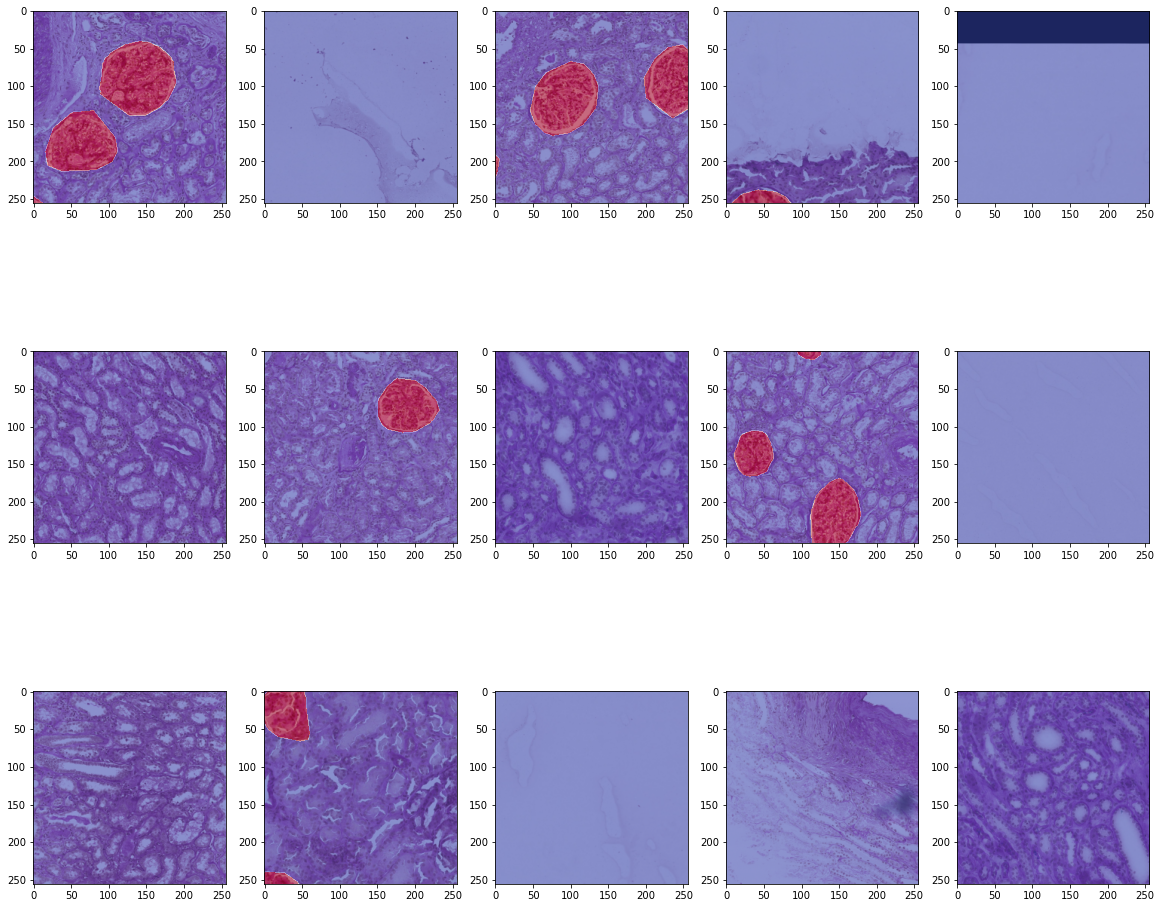

In [15]:
imgs = [Image.open(img_path) for img_path in train_img_paths]
masks = [Image.open(mask_path) for mask_path in train_mask_paths]
display_pil_images(imgs[300:500], masks[300:500])

Showing 15 images of 50:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


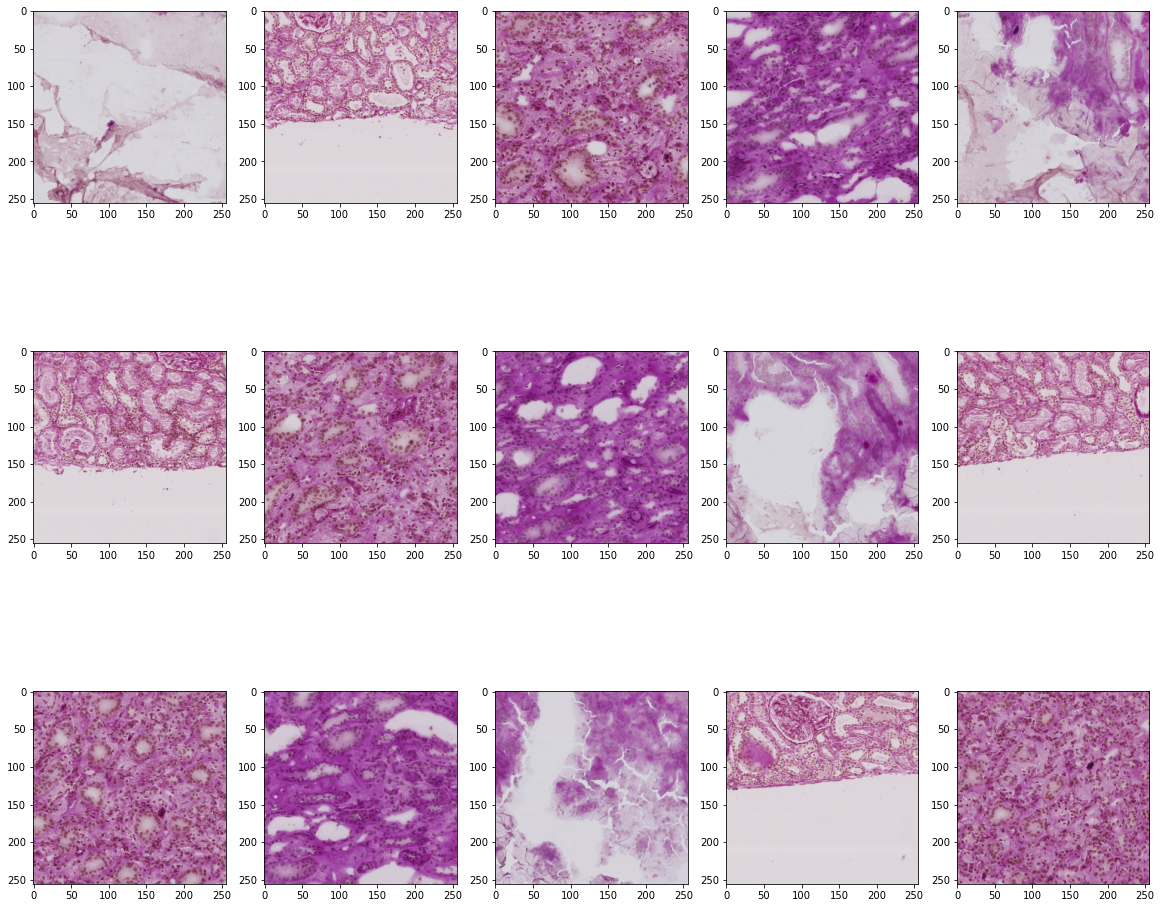

In [16]:
imgs = [Image.open(img_path) for img_path in test_img_paths]
display_pil_images(imgs[450:500])

### Dataset class

In [17]:
class HuBMAPDataset(D.Dataset):
    
    def __init__(
            self, 
            paths, 
            mode,
            augmentation=None,
            preprocessing=None,
    ):

        self.paths = paths
        self.mode = mode
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __getitem__(self, i):       
        if self.mode in ['train', 'val']:
            image = cv.imread(self.paths[i][0])
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            mask = cv.imread(self.paths[i][1], 0)
            mask = np.expand_dims(mask, axis=2)
        else:
            image = cv.imread(self.paths[i])
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        if self.augmentation:
            if self.mode in ['train', 'val']:
                sample = self.augmentation(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
            else:
                sample = self.augmentation(image=image)
                image = sample['image']

        if self.preprocessing:
            if self.mode in ['train', 'val']:
                sample = self.preprocessing(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
            else:
                sample = self.preprocessing(image=image)
                image = sample['image']

        if self.mode in ['train', 'val']:
            return image, mask
        
        return image
        
    def __len__(self):
        return len(self.paths)

In [18]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomRotate90(p=0.5),
        albu.Transpose(p=0.5),
        
        albu.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0, shift_limit=0.2, p=0.2, border_mode=0),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        
        albu.Compose([
            albu.VerticalFlip(p=0.5),              
            albu.RandomRotate90(p=0.5)]
        )
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing():
    _transform = [
        albu.Normalize(mean=(0.65459856,0.48386562,0.69428385), 
                       std=(0.15167958,0.23584107,0.13146145), 
                       max_pixel_value=255.0, always_apply=True, p=1.0),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

### Result

In [19]:
train_paths, val_paths = train_test_split(list(zip(train_img_paths, train_mask_paths)),
                                        test_size=0.2,  
                                        random_state=SEED,
                                        shuffle=True)

print("Amount of train samples:", len(train_paths))
print("Amount of val samples:", len(val_paths))

Amount of train samples: 3001
Amount of val samples: 751


In [20]:
# augmented_dataset = HuBMAPDataset(train_paths,
#                                   'train',
#                                   augmentation=get_training_augmentation(),
#                                 )

# for i in range(20):
#     image, mask = augmented_dataset[1]
#     visualize(image=image, mask=mask.squeeze(-1))

### Model

In [21]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' 
LR = 1e-4

model = smp.UnetPlusPlus(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS, activation=ACTIVATION)

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=LR),
])

Check integrity of dataset

### Train/val dataloaders

In [22]:
train_dataset = HuBMAPDataset(train_paths, 
                              'train',
                              augmentation=get_training_augmentation(), 
                              preprocessing=get_preprocessing()
                            )

valid_dataset = HuBMAPDataset(val_paths,
                              'val',
                              augmentation=get_validation_augmentation(), 
                              preprocessing=get_preprocessing()
                            )

train_loader = D.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = D.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

### Train Loop

In [23]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=False,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=False,
)

In [24]:
# umount /dev/shm/ && sudo mount -t tmpfs -o rw,nosuid,nodev,noexec,relatime,size=10G shm /dev/shm

In [26]:
best_loss = 1.0

train_losses, val_losses = [], []
train_scores, val_scores = [], []

tbar = tqdm(range(0, NUM_EPOCHS), total = NUM_EPOCHS)
for i in tbar:
    
    print(f'\nEpoch: {i}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    train_losses.append(train_logs['dice_loss'])
    val_losses.append(valid_logs['dice_loss'])
    train_scores.append(train_logs['iou_score'])
    val_scores.append(valid_logs['iou_score'])
    
    tbar.set_description('val score - {:.4f}'.format(valid_logs['iou_score']))
    
    if best_loss > valid_logs['dice_loss']:
        best_loss = valid_logs['dice_loss']
        torch.save(model, os.path.join(MODEL_SAVE_DIR, 'best_model.pth'))
        print(f'Model saved! Best valid loss: {best_loss:.4f} valid iou score: {valid_logs["iou_score"]}')

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Model saved! Best valid loss: 0.7857 valid iou score: 0.4788266759603582

Epoch: 1
Model saved! Best valid loss: 0.5957 valid iou score: 0.7342358187158057

Epoch: 2
Model saved! Best valid loss: 0.3681 valid iou score: 0.7426861670423063

Epoch: 3
Model saved! Best valid loss: 0.2506 valid iou score: 0.7751661437623044

Epoch: 4
Model saved! Best valid loss: 0.1910 valid iou score: 0.7874006743126728

Epoch: 5
Model saved! Best valid loss: 0.1628 valid iou score: 0.7908598729904662

Epoch: 6
Model saved! Best valid loss: 0.1411 valid iou score: 0.8067583264188564

Epoch: 7
Model saved! Best valid loss: 0.1362 valid iou score: 0.7965304483758643

Epoch: 8
Model saved! Best valid loss: 0.1359 valid iou score: 0.7931388692652923

Epoch: 9

Epoch: 10
Model saved! Best valid loss: 0.1252 valid iou score: 0.7968404597424443

Epoch: 11

Epoch: 12
Model saved! Best valid loss: 0.1193 valid iou score: 0.8021355943476901

Epoch: 13
Model saved! Best valid loss: 0.1154 valid iou score:

In [27]:
np.array(val_scores).argmax(), np.array(val_scores).max()

(6, 0.8067583264188564)

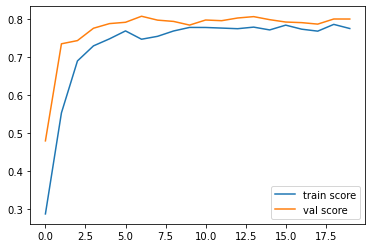

In [28]:
plt.figure()
plt.plot(train_scores, label='train score')
plt.plot(val_scores, label='val score')
plt.legend()
plt.show();